<h1><center>Metody uczenia maszynowego</center></h1>
<h3><center><ul style="list-style: none;">
    <li>Patrycja Szczakowska ???</li>
    <li>Maciej Majchrowski ???</li>
    <li>Mateusz Gałasiński 234054</li>
    <li>Jakub Kurek 234078</li>
    </ul></center></h3> 
<h2><center>Zadanie 2 - Klastryzacja danych - uczenie nienadzorowane</center></h2>

### Zależności

In [20]:
# install additional packages
!pip install k3d > /dev/null
%matplotlib notebook

In [2]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as pypl
from pandas import read_csv
import json

## Konfiguracja

In [5]:
class Config(object):
    def __init__(self, dataSourceUrl, quantitativeColumns, qualitativeColumns):
        self.dataSourceUrl = dataSourceUrl
        self.quantitativeColumns = quantitativeColumns
        self.qualitativeColumns = qualitativeColumns
def as_config(dct):
    return Config(
        dct['dataSourceUrl'],
        dct['quantitativeColumns'],
        dct['qualitativeColumns'],)
json_config ="""
{
    "dataSourceUrl": "/home/jovyan/host-note/data/fertility_Diagnosis.data",
    "quantitativeColumns": [
        "season"
    ],
    "qualitativeColumns": [
        "age"
    ]
}"""
config = json.loads(json_config, object_hook = as_config)

## Opis zbiorów danych

In [7]:
for line in [line for line in Path(config.dataSourceUrl).read_text().splitlines() if line]:
    print(line)

season,age,childish_disease,accident_trauma,surgical_treatmnent,fevers,alcohol_consumption,smoking_habit,hours_sitting,output_diagnosis
-0.33,0.69,0,1,1,0,0.8,0,0.88,N
-0.33,0.94,1,0,1,0,0.8,1,0.31,O
-0.33,0.5,1,0,0,0,1,-1,0.5,N
-0.33,0.75,0,1,1,0,1,-1,0.38,N
-0.33,0.67,1,1,0,0,0.8,-1,0.5,O
-0.33,0.67,1,0,1,0,0.8,0,0.5,N
-0.33,0.67,0,0,0,-1,0.8,-1,0.44,N
-0.33,1,1,1,1,0,0.6,-1,0.38,N
1,0.64,0,0,1,0,0.8,-1,0.25,N
1,0.61,1,0,0,0,1,-1,0.25,N
1,0.67,1,1,0,-1,0.8,0,0.31,N
1,0.78,1,1,1,0,0.6,0,0.13,N
1,0.75,1,1,1,0,0.8,1,0.25,N
1,0.81,1,0,0,0,1,-1,0.38,N
1,0.94,1,1,1,0,0.2,-1,0.25,N
1,0.81,1,1,0,0,1,1,0.5,N
1,0.64,1,0,1,0,1,-1,0.38,N
1,0.69,1,0,1,0,0.8,-1,0.25,O
1,0.75,1,1,1,0,1,1,0.25,N
1,0.67,1,0,0,0,0.8,1,0.38,O
1,0.67,0,0,1,0,0.8,-1,0.25,N
1,0.75,1,0,0,0,0.6,0,0.25,N
1,0.67,1,1,0,0,0.8,-1,0.25,N
1,0.69,1,0,1,-1,1,-1,0.44,O
1,0.56,1,0,1,0,1,-1,0.63,N
1,0.67,1,0,0,0,1,-1,0.25,N
1,0.67,1,0,1,0,0.6,-1,0.38,O
1,0.78,1,1,0,1,0.6,-1,0.38,O
1,0.58,0,0,1,0,1,-1,0.19,N
1,0.67,0,0,1,0,0.6,0,0.5,O
1

## Divide into qualitative and quantitative

In [16]:
def load_dataset():
    global dataset
    dataset = read_csv(config.dataSourceUrl, header=0)
#     global qualitativeDataset = dataset[config.qualitativeColumns]
#     global quantitativeDataset = dataset[config.quantitativeColumns]
    print(dataset.shape)
    dataset.describe()

### Modes

In [11]:
# qualitativeDataset.mode()

## 2. Correlation matrix
*Narysować histogramy dla dwóch cech ilościowych najbardziej ze sobą skorelowanych*

In [12]:
# quantitativeDataset.corr()

### Histogram for attributes with highest correlation


In [13]:
# corr = quantitativeDataset.corr()
# max = -2
# c, r = "", ""
# for column in corr:
#     for row in corr:
#         if row != column and np.absolute(corr[column][row]) > max:
#             max = np.absolute(corr[column][row])
#             c = column
#             r = row
# hist = quantitativeDataset.hist(column=[c, r])

# Pętla aplikacji

(100, 10)


<IPython.core.display.Javascript object>


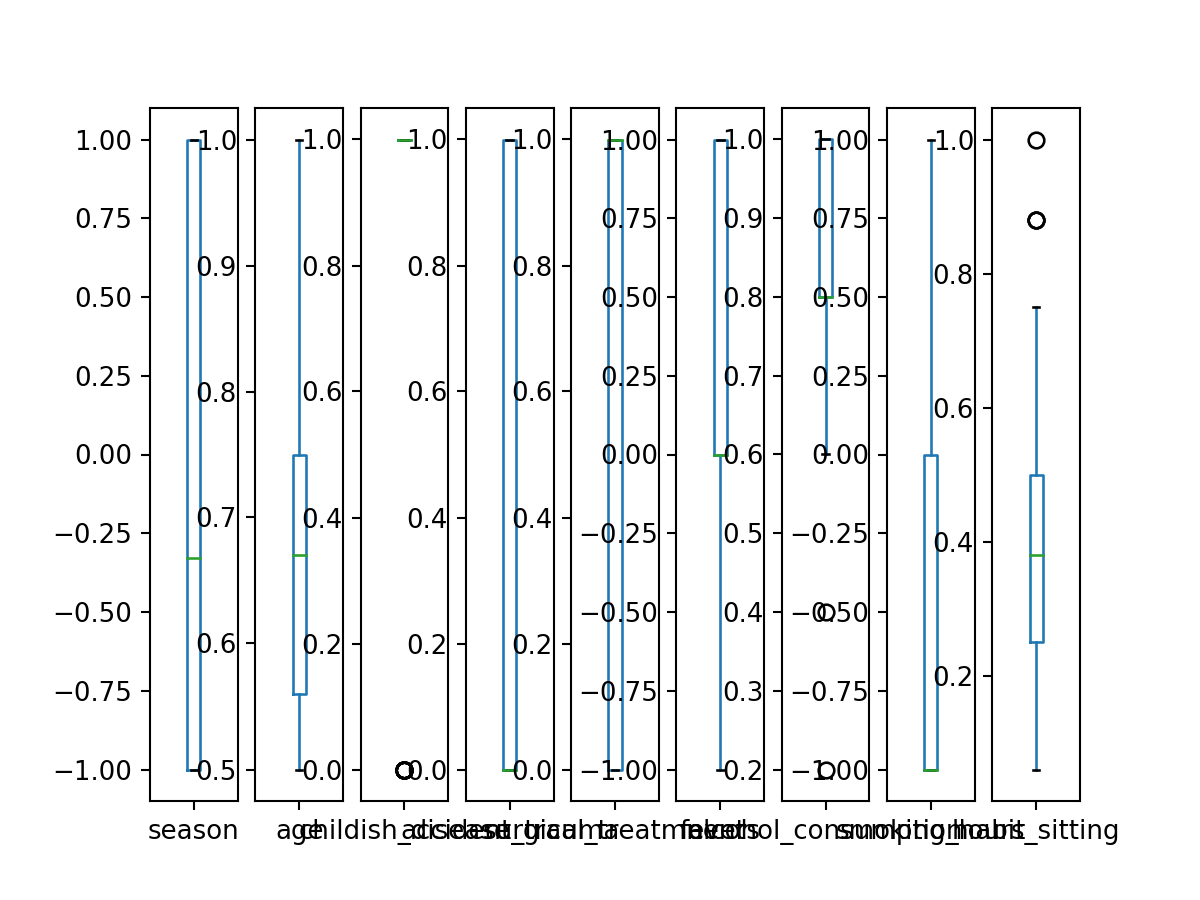

<IPython.core.display.Javascript object>


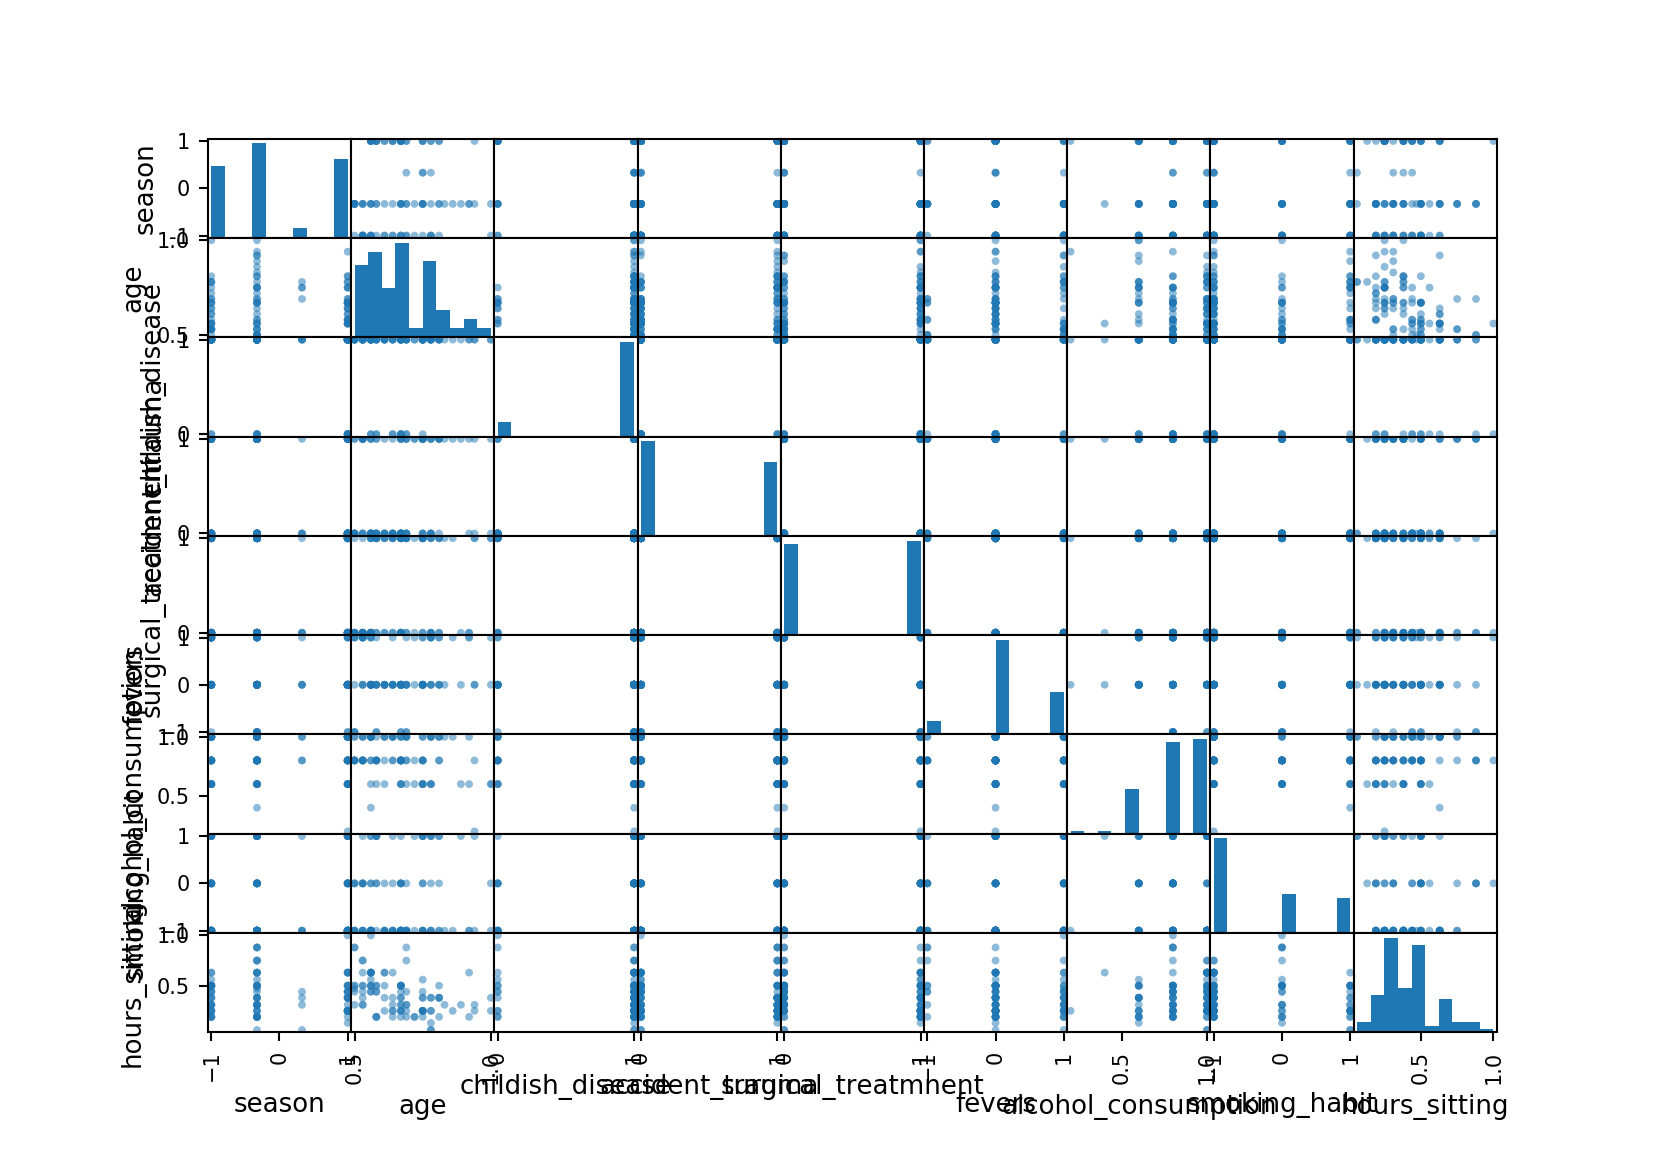

---------------------------
Running clustering for: KNN
1.3628981692871192


In [21]:
import sys
import scipy
import numpy
import matplotlib
import pandas
import sklearn
# Load libraries
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import calinski_harabasz_score, pairwise_distances, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure
from sklearn.cluster import KMeans

load_dataset()
dataset.plot(kind='box', subplots=True, sharex=False, sharey=False)
pyplot.show()

scatter_matrix(dataset)
pyplot.show()

array = dataset.values
x = array[:,0:len(dataset.columns)-1]
labels_true = array[:,len(dataset.columns)-1]

models = []
models.extend([
    ('KNN', KMeans(n_clusters=3, random_state=1), 0),
])
results = []
names = []
for name, model, subplot_row in models:
    print(f"---------------------------\nRunning clustering for: {name}")
    # kfold = StratifiedKFold(n_splits=cfg.n_splits, random_state=1, shuffle=True)
    # cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    # results.append(cv_results)
    # names.append(name)
    # print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    # Make predictions on validation dataset
    clustering = model.fit(x)
    print(davies_bouldin_score(x, clustering.labels_)) 